# Conecta AI Agent Hallucination Analysis

## Multi-Agent Evaluation System

This notebook implements a **Multi-Agent Specialist Pipeline** to analyze Conecta's performance:

**Agents:**
1. 🔍 **Document Relevance Agent** (Gemini Flash) - Checks if retrieved documents are relevant
2. 🚨 **Hallucination Detector** (Gemini Pro) - **CRITICAL** - Detects made-up information
3. ✅ **Completeness Checker** (Gemini Flash) - Validates response completeness
4. 🎯 **Escalation Validator** (Gemini Flash) - Judges if escalation was appropriate
5. 🔬 **Verification Agent** (Gemini Pro) - Secondary verification for critical findings

**Focus:** Detecting when Conecta makes up information (Priority #1)

## 1. Setup & Configuration

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path

# Add src to path
sys.path.insert(0, os.path.abspath('..'))

# Import our modules
from src.config import EvaluatorConfig, ProviderType, ModelType
from src.data.loader import load_all_data, get_data_summary
from src.etl.merger import merge_all_datasets, enrich_with_documents, create_conversation_summary
from src.orchestrator import EvaluationOrchestrator, ConversationData

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Setup complete!")

✅ Setup complete!


### Configure API Access

Choose between **Gemini** or **Vertex AI**

In [2]:
# OPTION 1: Use Gemini (recommended for development)
config = EvaluatorConfig(
    provider=ProviderType.GEMINI,
    gemini_api_key=os.getenv('GEMINI_API_KEY'),  # Set via environment variable
    flash_model_name="gemini-2.0-flash",
    pro_model_name="gemini-2.0-flash",
    hallucination_detector_model=ModelType.PRO,  # Use Pro for critical task
    verification_agent_model=ModelType.PRO,
    parallel_agents=True  # Run agents in parallel for speed
)

# OPTION 2: Use Vertex AI (uncomment if using Vertex)
# config = EvaluatorConfig(
#     provider=ProviderType.VERTEX,
#     vertex_project_id=os.getenv('VERTEX_PROJECT_ID'),
#     vertex_location="us-central1",
#     flash_model_name="gemini-2.0-flash-exp",
#     pro_model_name="gemini-1.5-pro-002",
#     hallucination_detector_model=ModelType.PRO,
#     verification_agent_model=ModelType.PRO,
#     parallel_agents=True
# )

config.validate()
print(f"✅ Using {config.provider.value} provider")
print(f"   Hallucination Detector: {config.get_model_name(config.hallucination_detector_model)}")
print(f"   Other Agents: {config.get_model_name(ModelType.FLASH)}")

✅ Using gemini provider
   Hallucination Detector: gemini-2.0-flash
   Other Agents: gemini-2.0-flash


## 2. Load and Merge Data

**ETL Pipeline:**
1. Load 4 CSV files
2. Extract Langfuse JSON data (document IDs, questions, responses)
3. Enrich with knowledge base content
4. Create conversation-level summary

In [3]:
# Load all data files
print("Loading data files...")
data = load_all_data(data_dir="..")

# Show summary
summary = get_data_summary(data)
print("\n📊 Data Summary:")
summary

2025-10-07 05:03:59,157 - src.data.loader - INFO - Loading data files...


Loading data files...


2025-10-07 05:03:59,785 - src.data.loader - INFO - Loaded conversations: 6,503 rows
2025-10-07 05:03:59,849 - src.data.loader - INFO - Loaded Genesys data: 737 rows
2025-10-07 05:04:00,355 - src.data.loader - INFO - Loaded Langfuse traces: 974 rows
2025-10-07 05:04:00,439 - src.data.loader - INFO - Loaded knowledge base: 2,375 rows



📊 Data Summary:


,dataset,rows,columns,memory_mb,key_columns
0,conversations,6503,29,25.351508,"id_tbl_preguntas_conversacion_conecta2, fk_tbl_conversaciones_conecta2, pregunta, respuesta, calificacion"
1,genesys,737,22,1.301772,"fk_tbl_conversaciones_conecta2, correo, motivo_experto, REGIONAL, interacciones"
2,langfuse,974,29,49.693695,"id, projectId, timestamp, tags, bookmarked"
3,knowledge_base,2375,18,6.030911,"idtbl_pregunta, titulo, respuesta, id_usuario_creador, fecha_creacion"


In [4]:
# Merge datasets to create analysis dataframe
print("Merging datasets...")
analysis_df = merge_all_datasets(data)

print(f"\n✅ Created analysis dataset with {len(analysis_df):,} interactions")
print(f"   Date range: {analysis_df['timestamp'].min()} to {analysis_df['timestamp'].max()}")
print(f"   Complete data (question + response + sources): {len(analysis_df):,}")

analysis_df.head()

2025-10-07 05:04:00,575 - src.etl.merger - INFO - Starting data merge process...
2025-10-07 05:04:00,591 - src.etl.merger - INFO - Attempting to link Langfuse data to conversations...
2025-10-07 05:04:00,597 - src.etl.json_extractor - INFO - Processing Langfuse data...


Merging datasets...


2025-10-07 05:04:00,844 - src.etl.json_extractor - WARNING - Failed to parse JSON: Expecting value: line 1 column 1 (char 0)
2025-10-07 05:04:01,047 - src.etl.json_extractor - INFO - Extracted sources from 974 traces
2025-10-07 05:04:01,062 - src.etl.merger - INFO - Found 559 complete Langfuse traces
2025-10-07 05:04:01,357 - src.etl.merger - INFO - Aggregated to 559 conversations
2025-10-07 05:04:01,362 - src.etl.merger - INFO - Multi-turn conversations: 0
2025-10-07 05:04:01,382 - src.etl.merger - INFO - Created analysis dataset with 559 interactions



✅ Created analysis dataset with 559 interactions
   Date range: 2025-09-18 17:07:41.130000+00:00 to 2025-09-25 16:56:54.436000+00:00
   Complete data (question + response + sources): 559


,id,projectId,timestamp,tags,bookmarked,name,release,version,userId,environment,sessionId,public,input,output,metadata,latency,usage,inputCost,outputCost,totalCost,level,errorCount,warningCount,defaultCount,debugCount,observationCount,inputTokens,outputTokens,totalTokens,output_parsed,input_parsed,sources,user_question,ai_response,need_expert,expert_category,user_message_count,prev_user_question,prev_ai_response,turn_number,total_turns
967,30db4218-89ed-4ed4-9432-090b49456e22,cm38vdgjp005z3hq2htm5f0mx,2025-09-18 17:14:36.791000+00:00,"[""agent_execution"",""conecta"",""conecta_structure_analysis"",""main_workflow""]",False,00321044-8b41-4410-8842-a80668b24362_main_graph,NaN,NaN,nico-test,default,00321044-8b41-4410-8842-a80668b24362,False,"{""TEAM_MEMBERS"":null,""TEAM_MEMBER_CONFIGURATIONS"":null,""messages"":[{""content"":""retiro en cajero internacional "",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name"":null,""id"":""3afc7...","{""messages"":[{""content"":""retiro en cajero internacional "",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name"":null,""id"":""3afc7e4e-a3e9-43d9-9a07-c9c0c8e826fb"",""example"":false},{""co...","{""tags"":[""conecta"",""main_workflow"",""agent_execution""],""execution_context"":""main_graph"",""project"":""conecta""}",29.422,"{""promptTokens"":41638,""completionTokens"":2076,""totalTokens"":43714}",0.007110,0.002603,0.010763,DEFAULT,0,0,51,26,77,41638,2076,43714,"{'messages': [{'content': 'retiro en cajero internacional ', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3afc7e4e-a3e9-43d9-9a07-c9c0c8e826fb', 'example...","{'TEAM_MEMBERS': None, 'TEAM_MEMBER_CONFIGURATIONS': None, 'messages': [{'content': 'retiro en cajero internacional ', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': No...","[6008, 1760, 186]",acumulacion de millas tarjeta avianca,La acumulación de millas con la tarjeta de crédito Visa Avianca Davivienda depende del segmento de la tarjeta que tengas:\n\n- Signature: 1.4 millas LifeMiles por cada dólar gastado\n- Platinum: 1...,False,186,6.0,NaN,NaN,1,1
610,9f88fb36-5c63-4661-919e-c79a98c121ec,cm38vdgjp005z3hq2htm5f0mx,2025-09-22 14:51:57.133000+00:00,"[""agent_execution"",""conecta"",""conecta_structure_analysis"",""main_workflow""]",False,00a26f92-3d15-4c53-9ac3-f99614c54900_main_graph,NaN,NaN,nico-test,default,00a26f92-3d15-4c53-9ac3-f99614c54900,False,"{""TEAM_MEMBERS"":null,""TEAM_MEMBER_CONFIGURATIONS"":null,""messages"":[{""content"":""intereses mal aplicados en la tarjetas d ecredito"",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name...","{""messages"":[{""content"":""intereses mal aplicados en la tarjetas d ecredito"",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name"":null,""id"":""478b85b0-291b-41d7-b0f5-709b1a96e0dc"",""ex...","{""tags"":[""conecta"",""main_workflow"",""agent_execution""],""execution_context"":""main_graph"",""project"":""conecta""}",66.115,"{""promptTokens"":36119,""completionTokens"":3119,""totalTokens"":39238}",0.006815,0.004374,0.012149,DEFAULT,0,0,51,26,77,36119,3119,39238,"{'messages': [{'content': 'intereses mal aplicados en la tarjetas d ecredito', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '478b85b0-291b-41d7-b0f5-709b1...","{'TEAM_MEMBERS': None, 'TEAM_MEMBER_CONFIGURATIONS': None, 'messages': [{'content': 'intereses mal aplicados en la tarjetas d ecredito', 'additional_kwargs': {}, 'response_metadata': {}, 'type': '...","[5815, 397]","Quiero saber qué hacer si me aplicaron intereses incorrectos en mi tarjeta de crédito Davivienda, cuál es el procedimiento para reclamar y ajustar esos intereses mal aplicados.","Si notas que te aplicaron intereses incorrectos en tu tarjeta de crédito Davivienda, puedes solicitar un ajuste para corregir este error. Aquí te explico cómo hacerlo:\n\n1. Primero, debes informa...",False,397,2.0,NaN

In [5]:
# Enrich with document content from knowledge base
print("Enriching with document content...")
enriched_df = enrich_with_documents(analysis_df, data['knowledge_base'])

print(f"\n✅ Enriched to {len(enriched_df):,} document-interaction pairs")

enriched_df.head()

2025-10-07 05:04:01,563 - src.etl.merger - INFO - Enriching with document content...
2025-10-07 05:04:01,565 - src.etl.json_extractor - INFO - Exploding sources to long format...


Enriching with document content...


2025-10-07 05:04:01,606 - src.etl.json_extractor - INFO - Exploded to 1701 document-trace pairs
2025-10-07 05:04:01,628 - src.etl.merger - INFO - Enriched 1701 document-interaction pairs
2025-10-07 05:04:01,631 - src.etl.merger - INFO - Successfully matched 1139/1701 documents (67.0%)



✅ Enriched to 1,701 document-interaction pairs


,id,projectId,timestamp,tags,bookmarked,name,release,version,userId,environment,sessionId,public,input,output,metadata,latency,usage,inputCost,outputCost,totalCost,level,errorCount,warningCount,defaultCount,debugCount,observationCount,inputTokens,outputTokens,totalTokens,output_parsed,input_parsed,document_id,user_question,ai_response,need_expert,expert_category,user_message_count,prev_user_question,prev_ai_response,turn_number,total_turns,doc_title,doc_content,doc_keywords
0,30db4218-89ed-4ed4-9432-090b49456e22,cm38vdgjp005z3hq2htm5f0mx,2025-09-18 17:14:36.791000+00:00,"[""agent_execution"",""conecta"",""conecta_structure_analysis"",""main_workflow""]",False,00321044-8b41-4410-8842-a80668b24362_main_graph,NaN,NaN,nico-test,default,00321044-8b41-4410-8842-a80668b24362,False,"{""TEAM_MEMBERS"":null,""TEAM_MEMBER_CONFIGURATIONS"":null,""messages"":[{""content"":""retiro en cajero internacional "",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name"":null,""id"":""3afc7...","{""messages"":[{""content"":""retiro en cajero internacional "",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name"":null,""id"":""3afc7e4e-a3e9-43d9-9a07-c9c0c8e826fb"",""example"":false},{""co...","{""tags"":[""conecta"",""main_workflow"",""agent_execution""],""execution_context"":""main_graph"",""project"":""conecta""}",29.422,"{""promptTokens"":41638,""completionTokens"":2076,""totalTokens"":43714}",0.007110,0.002603,0.010763,DEFAULT,0,0,51,26,77,41638,2076,43714,"{'messages': [{'content': 'retiro en cajero internacional ', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3afc7e4e-a3e9-43d9-9a07-c9c0c8e826fb', 'example...","{'TEAM_MEMBERS': None, 'TEAM_MEMBER_CONFIGURATIONS': None, 'messages': [{'content': 'retiro en cajero internacional ', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': No...",6008.0,acumulacion de millas tarjeta avianca,La acumulación de millas con la tarjeta de crédito Visa Avianca Davivienda depende del segmento de la tarjeta que tengas:\n\n- Signature: 1.4 millas LifeMiles por cada dólar gastado\n- Platinum: 1...,False,186,6.0,NaN,NaN,1,1,Acumulación correcta de las millas en la cuenta LifeMiles,Puedes verificar a través de AS400 en la opción LER de AS400 el detalle de la acumulación de millas con el siguiente proceso:Ingresar tipo y número de documento de identificación.Digitar 7 y luego...,"tarjeta_credito, acumulacion_millas, lifemiles"
1,30db4218-89ed-4ed4-9432-090b49456e22,cm38vdgjp005z3hq2htm5f0mx,2025-09-18 17:14:36.791000+00:00,"[""agent_execution"",""conecta"",""conecta_structure_analysis"",""main_workflow""]",False,00321044-8b41-4410-8842-a80668b24362_main_graph,NaN,NaN,nico-test,default,00321044-8b41-4410-8842-a80668b24362,False,"{""TEAM_MEMBERS"":null,""TEAM_MEMBER_CONFIGURATIONS"":null,""messages"":[{""content"":""retiro en cajero internacional "",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name"":null,""id"":""3afc7...","{""messages"":[{""content"":""retiro en cajero internacional "",""additional_kwargs"":{},""response_metadata"":{},""type"":""human"",""name"":null,""id"":""3afc7e4e-a3e9-43d9-9a07-c9c0c8e826fb"",""example"":false},{""co...","{""tags"":[""conecta"",""main_workflow"",""agent_execution""],""execution_context"":""main_graph"",""project"":""conecta""}",29.422,"{""promptTokens"":41638,""completionTokens"":2076,""totalTokens"":43714}",0.007110,0.002603,0.010763,DEFAULT,0,0,51,26,77,41638,2076,43714,"{'messages': [{'content': 'retiro en cajero internacional ', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '3afc7e4e-a3e9-43d9-9a07-c9c0c8e826fb', 'example...","{'TEAM_MEMBERS': None, 'TEAM_MEMBER_CONFIGURATIONS': None, 'messages': [{'content': 'retiro en cajero internacional ', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': No...",1760.0,acumulacion de millas tarjeta avianca,La acumulación de millas con la 

In [6]:
# Create conversation-level summary (aggregates all documents per conversation)
print("Creating conversation-level summary...")
conversation_df = create_conversation_summary(enriched_df)

print(f"\n✅ Created {len(conversation_df):,} conversations ready for evaluation")

# Preview
conversation_df[['sessionId', 'user_question', 'ai_response', 'need_expert']].head()

2025-10-07 05:04:02,039 - src.etl.merger - INFO - Creating conversation-level summary...


Creating conversation-level summary...


2025-10-07 05:04:02,358 - src.etl.merger - INFO - Created summary for 559 conversations



✅ Created 559 conversations ready for evaluation


,sessionId,user_question,ai_response,need_expert
0,00321044-8b41-4410-8842-a80668b24362,acumulacion de millas tarjeta avianca,La acumulación de millas con la tarjeta de crédito Visa Avianca Davivienda depende del segmento de la tarjeta que tengas:\n\n- Signature: 1.4 millas LifeMiles por cada dólar gastado\n- Platinum: 1...,False
1,00a26f92-3d15-4c53-9ac3-f99614c54900,"Quiero saber qué hacer si me aplicaron intereses incorrectos en mi tarjeta de crédito Davivienda, cuál es el procedimiento para reclamar y ajustar esos intereses mal aplicados.","Si notas que te aplicaron intereses incorrectos en tu tarjeta de crédito Davivienda, puedes solicitar un ajuste para corregir este error. Aquí te explico cómo hacerlo:\n\n1. Primero, debes informa...",False
2,0100fd52-c9ce-47ad-8052-5704b3089a12,cliente quiere cancelar el paquete de servicios bolivar,"Para cancelar el paquete de servicios de Seguros Bolívar, el cliente debe comunicarse directamente con Seguros Bolívar a través de los siguientes canales:\n\n1. Teléfono en Bogotá: 3122122\n2. Tel...",False
3,010b0c54-e28c-43cc-9717-a19d41bc0a16,de que se trata la etapa 08 gestión documental en la solicitud de una compra de cartera a través de la app,"La información específica sobre la etapa 08, denominada ""gestión documental"", en la solicitud de compra de cartera a través de la app no está detallada en los documentos disponibles. Sin embargo, ...",False
4,0145bc9b-abe3-4869-8e83-16a0c15e3b51,como cancelo una fiducia estructurada??,"Para cancelar una fiducia estructurada en Davivienda, el proceso puede variar según el tipo de producto, pero generalmente se maneja como la cancelación de un fondo de inversión o un producto fidu...",False


## 3. Run Multi-Agent Evaluation

**Architecture:**
- Stage 1: Run 4 agents in parallel (hallucination, relevance, completeness, escalation)
- Stage 2: If hallucination detected → Run verification agent

**Cost Estimate (per 1,000 conversations):**
- Gemini Flash (3 agents): ~$1.30
- Gemini Pro (hallucination + verification): ~$2.40
- **Total: ~$3.70 per 1,000 conversations**

In [7]:
# Initialize orchestrator
print("Initializing evaluation orchestrator...")
orchestrator = EvaluationOrchestrator(config)
print("✅ Orchestrator ready!")

2025-10-07 05:04:02,532 - src.orchestrator - INFO - Initializing EvaluationOrchestrator...
2025-10-07 05:04:02,546 - src.evaluators.factory - INFO - Creating Gemini provider with model: gemini-2.0-flash
2025-10-07 05:04:02,555 - src.evaluators.providers.gemini_provider - INFO - Initialized Gemini provider with model: gemini-2.0-flash
2025-10-07 05:04:02,572 - src.evaluators.factory - INFO - Creating Gemini provider with model: gemini-2.0-flash


Initializing evaluation orchestrator...


2025-10-07 05:04:02,578 - src.evaluators.providers.gemini_provider - INFO - Initialized Gemini provider with model: gemini-2.0-flash
2025-10-07 05:04:02,583 - src.evaluators.factory - INFO - Created 2 unique providers for 5 agents
2025-10-07 05:04:02,596 - src.orchestrator - INFO - Initialized 5 evaluation agents


✅ Orchestrator ready!


### Test on Single Conversation

Test the system on one conversation first

In [8]:
# Test on first conversation
test_row = conversation_df.iloc[4]

test_conversation = ConversationData(
    session_id=test_row['sessionId'],
    user_question=test_row['user_question'],
    ai_response=test_row['ai_response'],
    documents=test_row['all_documents'],
    escalated=test_row['need_expert']
)

print("Running test evaluation...")
print(f"Session: {test_conversation.session_id}")
print(f"\nQuestion: {test_conversation.user_question[:200]}...")
print(f"\nResponse: {test_conversation.ai_response[:200]}...")

test_result = orchestrator.evaluate_conversation(test_conversation)

print("\n" + "="*80)
print("TEST RESULTS")
print("="*80)

if test_result.success:
    print("\n🚨 HALLUCINATION CHECK:")
    if test_result.hallucination:
        hall = test_result.hallucination
        print(f"   Detected: {hall['hallucination_detected']}")
        print(f"   Severity: {hall['severity']}")
        print(f"   Type: {hall['hallucination_type']}")
        print(f"   Grounding Ratio: {hall['grounding_ratio']:.2%}")
        print(f"   Assessment: {hall['overall_assessment']}")
    
    print("\n🔍 DOCUMENT RELEVANCE:")
    if test_result.document_relevance:
        doc = test_result.document_relevance
        print(f"   Score: {doc['relevance_score']}/5")
        print(f"   Has Answer: {doc['has_answer']}")
    
    print("\n✅ COMPLETENESS:")
    if test_result.completeness:
        comp = test_result.completeness
        print(f"   Score: {comp['completeness_score']}/5")
        print(f"   Used All Info: {comp['used_all_relevant_info']}")
        print(f"   Unnecessary Clarification: {comp['unnecessary_clarification']}")
    
    if test_result.verification:
        print("\n🔬 VERIFICATION (Critical Finding):")
        ver = test_result.verification
        print(f"   Verified: {ver['verified']}")
        print(f"   New Severity: {ver['new_severity']}")
        print(f"   Recommendation: {ver['final_recommendation']}")
else:
    print(f"❌ Evaluation failed: {test_result.error}")

2025-10-07 05:04:02,691 - src.orchestrator - INFO - Evaluating conversation: 0145bc9b-abe3-4869-8e83-16a0c15e3b51
2025-10-07 05:04:02,699 - src.evaluators.base.HallucinationDetector - INFO - Running HallucinationDetector evaluation...
2025-10-07 05:04:02,736 - src.evaluators.base.DocumentRelevanceAgent - INFO - Running DocumentRelevanceAgent evaluation...


Running test evaluation...
Session: 0145bc9b-abe3-4869-8e83-16a0c15e3b51

Question: como cancelo una fiducia estructurada??...

Response: Para cancelar una fiducia estructurada en Davivienda, el proceso puede variar según el tipo de producto, pero generalmente se maneja como la cancelación de un fondo de inversión o un producto fiduciar...


2025-10-07 05:04:02,747 - src.evaluators.base.CompletenessChecker - INFO - Running CompletenessChecker evaluation...
2025-10-07 05:04:02,770 - src.evaluators.base.EscalationValidator - INFO - Running EscalationValidator evaluation...


E0000 00:00:1759831442.801264   78566 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759831442.801584   78570 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759831442.802612   78573 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1759831442.805901   78571 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
2025-10-07 05:04:17,701 - src.evaluators.base.EscalationValidator - INFO - EscalationValidator completed successfully
2025-10-07 05:04:17,709 - src.evaluators.base.DocumentRelevanceAgent - INFO - DocumentRelevanceAgent completed successfully
2025-10-07 05:04:19,035 - src.evaluators.base.CompletenessChecker - INFO - CompletenessChecker completed successfully
2025-10-07 05:04:28,125 - src.evaluators.base.HallucinationDetector - INFO - HallucinationDetect


TEST RESULTS

🚨 HALLUCINATION CHECK:
   Detected: False
   Severity: none
   Type: none
   Grounding Ratio: 100.00%
   Assessment: The response attempts to provide a general cancellation process for 'fiducia estructurada' by drawing parallels with 'Fondos de Inversión' and 'Dafuturo'. While some steps are grounded in the documents, the initial assumption and application of these steps to 'fiducia estructurada' is a mixing hallucination. The documents do not explicitly address the cancellation of 'fiducia estructurada'.

🔍 DOCUMENT RELEVANCE:
   Score: 3/5
   Has Answer: True

✅ COMPLETENESS:
   Score: 4/5
   Used All Info: False
   Unnecessary Clarification: False


### Run Full Evaluation

Process all conversations with complete Langfuse data

In [9]:
conversation_df_copy = conversation_df.copy()

In [10]:
sample_size = 10
conversation_df = conversation_df.head(sample_size)

In [11]:
# Prepare conversation data for batch evaluation
conversations_to_evaluate = []

for idx, row in conversation_df.iterrows():
    conv = ConversationData(
        session_id=row['sessionId'],
        user_question=row['user_question'],
        ai_response=row['ai_response'],
        documents=row['all_documents'],
        escalated=row['need_expert']
    )
    conversations_to_evaluate.append(conv)

print(f"Prepared {len(conversations_to_evaluate)} conversations for evaluation")

Prepared 10 conversations for evaluation


In [12]:
# Run batch evaluation
# NOTE: This will cost approximately $3.70 per 1,000 conversations

print(f"\n⚠️  COST ESTIMATE: ~${len(conversations_to_evaluate) * 0.0037:.2f} for {len(conversations_to_evaluate)} conversations")
print("\nStarting batch evaluation...")

evaluation_results = orchestrator.evaluate_batch(
    conversations_to_evaluate,
    run_verification=True,
    max_workers=3  # Parallel workers
)

print("\n✅ Batch evaluation complete!")

2025-10-07 05:04:29,064 - src.orchestrator - INFO - Starting batch evaluation of 10 conversations...
2025-10-07 05:04:29,078 - src.orchestrator - INFO - Evaluating conversation: 00321044-8b41-4410-8842-a80668b24362
2025-10-07 05:04:29,079 - src.orchestrator - INFO - Evaluating conversation: 00a26f92-3d15-4c53-9ac3-f99614c54900
2025-10-07 05:04:29,080 - src.orchestrator - INFO - Evaluating conversation: 0100fd52-c9ce-47ad-8052-5704b3089a12
2025-10-07 05:04:29,095 - src.evaluators.base.HallucinationDetector - INFO - Running HallucinationDetector evaluation...
2025-10-07 05:04:29,108 - src.evaluators.base.DocumentRelevanceAgent - INFO - Running DocumentRelevanceAgent evaluation...
2025-10-07 05:04:29,111 - src.evaluators.base.CompletenessChecker - INFO - Running CompletenessChecker evaluation...
2025-10-07 05:04:29,119 - src.evaluators.base.EscalationValidator - INFO - Running EscalationValidator evaluation...
2025-10-07 05:04:29,127 - src.evaluators.base.HallucinationDetector - INFO - Ru


⚠️  COST ESTIMATE: ~$0.04 for 10 conversations

Starting batch evaluation...


2025-10-07 05:04:29,275 - src.evaluators.base.CompletenessChecker - INFO - Running CompletenessChecker evaluation...
2025-10-07 05:04:29,282 - src.evaluators.base.EscalationValidator - INFO - Running EscalationValidator evaluation...
2025-10-07 05:04:30,566 - src.evaluators.base.CompletenessChecker - INFO - CompletenessChecker completed successfully
2025-10-07 05:04:30,954 - src.evaluators.base.EscalationValidator - INFO - EscalationValidator completed successfully
2025-10-07 05:04:31,005 - src.evaluators.base.DocumentRelevanceAgent - INFO - DocumentRelevanceAgent completed successfully
2025-10-07 05:04:31,012 - src.evaluators.base.CompletenessChecker - INFO - CompletenessChecker completed successfully
2025-10-07 05:04:31,197 - src.evaluators.base.DocumentRelevanceAgent - INFO - DocumentRelevanceAgent completed successfully
2025-10-07 05:04:31,226 - src.evaluators.base.EscalationValidator - INFO - EscalationValidator completed successfully
2025-10-07 05:04:31,455 - src.evaluators.base.


✅ Batch evaluation complete!


## 4. Analysis & Results

In [13]:
# Convert results to DataFrame
results_list = [r.to_dict() for r in evaluation_results]
results_df = pd.DataFrame(results_list)

print(f"✅ Created results dataframe with {len(results_df)} evaluations")
print(f"   Successful: {results_df['success'].sum()}")
print(f"   Failed: {(~results_df['success']).sum()}")

results_df.head()

✅ Created results dataframe with 10 evaluations
   Successful: 10
   Failed: 0


,session_id,success,error,hall_hallucination_detected,hall_severity,hall_severity_score,hall_hallucination_type,hall_total_claims,hall_grounded_claims,hall_hallucinated_claims,hall_grounding_ratio,hall_confidence,hall_overall_assessment,hall_evidence,hall_hallucinated_claim_details,hall_grounded_claim_details,doc_relevance_score,doc_has_answer,doc_missing_information,doc_relevant_documents,doc_irrelevant_documents,doc_explanation,comp_completeness_score,comp_used_all_relevant_info,comp_missing_information,comp_unnecessary_clarification,comp_explanation,esc_escalation_appropriate,esc_should_have_escalated,esc_reason,esc_alternative_action
0,0100fd52-c9ce-47ad-8052-5704b3089a12,True,None,False,none,0,none,3,3,0,1.0,0.8,"The response is mostly grounded in the provided documents. However, the response mixes information from different documents without explicitly stating that the cancellation process might vary depe...","[{'claim': 'Para cancelar el paquete de servicios de Seguros Bolívar, el cliente debe comunicarse directamente con Seguros Bolívar a través de los siguientes canales: 1. Teléfono en Bogotá: 31221...",[],"[{'claim': 'Para cancelar el paquete de servicios de Seguros Bolívar, el cliente debe comunicarse directamente con Seguros Bolívar a través de los siguientes canales: 1. Teléfono en Bogotá: 31221...",4,True,[],"[2383.0, 1174.0, 7032.0]",[],"The documents provide information on how to cancel insurance policies with Seguros Bolivar, including phone numbers and processes. They address cancellation processes which is relevant to the user...",5,True,[],False,"The response accurately and completely answers the user's question using all relevant information from the provided documents. It provides the correct contact information for Seguros Bolivar, incl...",True,False,The response provided by Conecta is accurate and directly addresses the user's question about canceling the Seguros Bolivar service package. The response includes the necessary contact information...,No alternative action needed. The response was appropriate.
1,00321044-8b41-4410-8842-a80668b24362,True,None,False,none,0,none,8,8,0,1.0,1.0,"All claims made by Conecta are supported by the provided documents. Therefore, no hallucinations were detected.","[{'claim': 'La acumulación de millas con la tarjeta de crédito Visa Avianca Davivienda depende del segmento de la tarjeta que tengas:', 'status': 'grounded', 'document_support': 'La acumulación de...",[],"[{'claim': 'La acumulación de millas con la tarjeta de crédito Visa Avianca Davivienda depende del segmento de la tarjeta que tengas:', 'status': 'grounded', 'document_support': 'La acumulación de...",5,True,[],"[Documento 6008.0, Documento 1760.0]",[],Both documents are highly relevant. Document 6008.0 explains how to verify the accumulation of miles in the LifeMiles account and how to associate a LifeMiles account to the card. Document 1760.0 ...,5,True,[],False,"Conecta's response includes all the relevant information from the provided documents. It details the accumulation rates for different card tiers, how miles are tracked, and how to manage LifeMiles...",True,False,"The response provided a comprehensive answer to the user's question about Avianca credit card mile accumulation. It detailed the accumulation rates for different card tiers, explained how miles ar...",No escalation was necessary. The response was adequate and helpful.
2,00a26f92-3d15-4c53-9ac3-f99614c54900,True,None,False,none,0,none,8,8,0,1.0,1.0,"All claims made by Conecta are supported by the provided document. Therefore, no hallucinations were detected.","[{'claim': 'Si notas que te aplicaron intereses incorrectos en tu tarjeta de crédito Davivienda, puedes solicitar un ajuste para corregir este error.', 'status': 'grounded', 'document_support': 'P...",[],"[{'claim': 'Si notas que te aplicaron intereses incorrectos en tu tarjeta de crédito Davivienda, puedes solicitar un ajuste para corregir este error.', 'status': 'grounded', 'documen

### 4.1 Hallucination Analysis (PRIORITY)

In [14]:
print("="*80)
print("🚨 HALLUCINATION ANALYSIS (CRITICAL)")
print("="*80)

successful_results = results_df[results_df['success']].copy()

hallucination_rate = successful_results['hall_hallucination_detected'].sum() / len(successful_results)
print(f"\n📊 Hallucination Rate: {hallucination_rate:.2%}")
print(f"   Total Conversations: {len(successful_results):,}")
print(f"   Hallucinations Detected: {successful_results['hall_hallucination_detected'].sum()}")

print("\n🔴 Severity Distribution:")
severity_dist = successful_results['hall_severity'].value_counts()
for severity, count in severity_dist.items():
    print(f"   {severity.upper()}: {count} ({count/len(successful_results)*100:.1f}%)")

print("\n📈 Hallucination Types:")
type_dist = successful_results['hall_hallucination_type'].value_counts()
for htype, count in type_dist.items():
    if htype != 'none':
        print(f"   {htype}: {count}")

print("\n🎯 Grounding Statistics:")
print(f"   Mean Grounding Ratio: {successful_results['hall_grounding_ratio'].mean():.2%}")
print(f"   Median Grounding Ratio: {successful_results['hall_grounding_ratio'].median():.2%}")
print(f"   Mean Claims per Response: {successful_results['hall_total_claims'].mean():.1f}")

🚨 HALLUCINATION ANALYSIS (CRITICAL)

📊 Hallucination Rate: 0.00%
   Total Conversations: 10
   Hallucinations Detected: 0

🔴 Severity Distribution:
   NONE: 10 (100.0%)

📈 Hallucination Types:

🎯 Grounding Statistics:
   Mean Grounding Ratio: 100.00%
   Median Grounding Ratio: 100.00%
   Mean Claims per Response: 4.9


In [15]:
# Identify critical hallucinations
critical_hallucinations = successful_results[
    (successful_results['hall_hallucination_detected']) &
    (successful_results['hall_severity'].isin(['major', 'critical']))
].copy()

print(f"\n🔥 CRITICAL HALLUCINATIONS: {len(critical_hallucinations)} cases")

if len(critical_hallucinations) > 0:
    print("\nTop critical cases:")
    for idx, row in critical_hallucinations.head().iterrows():
        print(f"\n   Session: {row['session_id']}")
        print(f"   Severity: {row['hall_severity']}")
        print(f"   Type: {row['hall_hallucination_type']}")
        print(f"   Assessment: {row['hall_overall_assessment'][:150]}...")


🔥 CRITICAL HALLUCINATIONS: 0 cases


### 4.2 Document Relevance & Completeness

In [16]:
print("="*80)
print("📚 DOCUMENT RELEVANCE ANALYSIS")
print("="*80)

print(f"\n   Mean Relevance Score: {successful_results['doc_relevance_score'].mean():.2f}/5")
print(f"   Conversations with Answer in Docs: {successful_results['doc_has_answer'].sum()} ({successful_results['doc_has_answer'].sum()/len(successful_results)*100:.1f}%)")

print("\n="*80)
print("✅ COMPLETENESS ANALYSIS")
print("="*80)

print(f"\n   Mean Completeness Score: {successful_results['comp_completeness_score'].mean():.2f}/5")
print(f"   Used All Relevant Info: {successful_results['comp_used_all_relevant_info'].sum()} ({successful_results['comp_used_all_relevant_info'].sum()/len(successful_results)*100:.1f}%)")
print(f"   Unnecessary Clarifications: {successful_results['comp_unnecessary_clarification'].sum()} ({successful_results['comp_unnecessary_clarification'].sum()/len(successful_results)*100:.1f}%)")

📚 DOCUMENT RELEVANCE ANALYSIS

   Mean Relevance Score: 3.40/5
   Conversations with Answer in Docs: 7 (70.0%)

=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
✅ COMPLETENESS ANALYSIS

   Mean Completeness Score: 4.60/5
   Used All Relevant Info: 8 (80.0%)
   Unnecessary Clarifications: 0 (0.0%)


### 4.3 Escalation Analysis

In [17]:
print("="*80)
print("🎯 ESCALATION ANALYSIS")
print("="*80)

# Merge with original escalation data
results_with_escalation = results_df.merge(
    conversation_df[['sessionId', 'need_expert']],
    left_on='session_id',
    right_on='sessionId',
    how='left'
)

escalated_count = results_with_escalation['need_expert'].sum()
print(f"\n   Total Escalated: {escalated_count} ({escalated_count/len(results_with_escalation)*100:.1f}%)")

if 'esc_escalation_appropriate' in successful_results.columns:
    appropriate = successful_results['esc_escalation_appropriate'].sum()
    print(f"   Appropriate Escalations: {appropriate} ({appropriate/len(successful_results)*100:.1f}%)")
    
    should_have = successful_results['esc_should_have_escalated'].sum()
    print(f"   Should Have Escalated: {should_have} ({should_have/len(successful_results)*100:.1f}%)")

🎯 ESCALATION ANALYSIS

   Total Escalated: 1 (10.0%)
   Appropriate Escalations: 10 (100.0%)
   Should Have Escalated: 1 (10.0%)


### 4.4 Visualizations

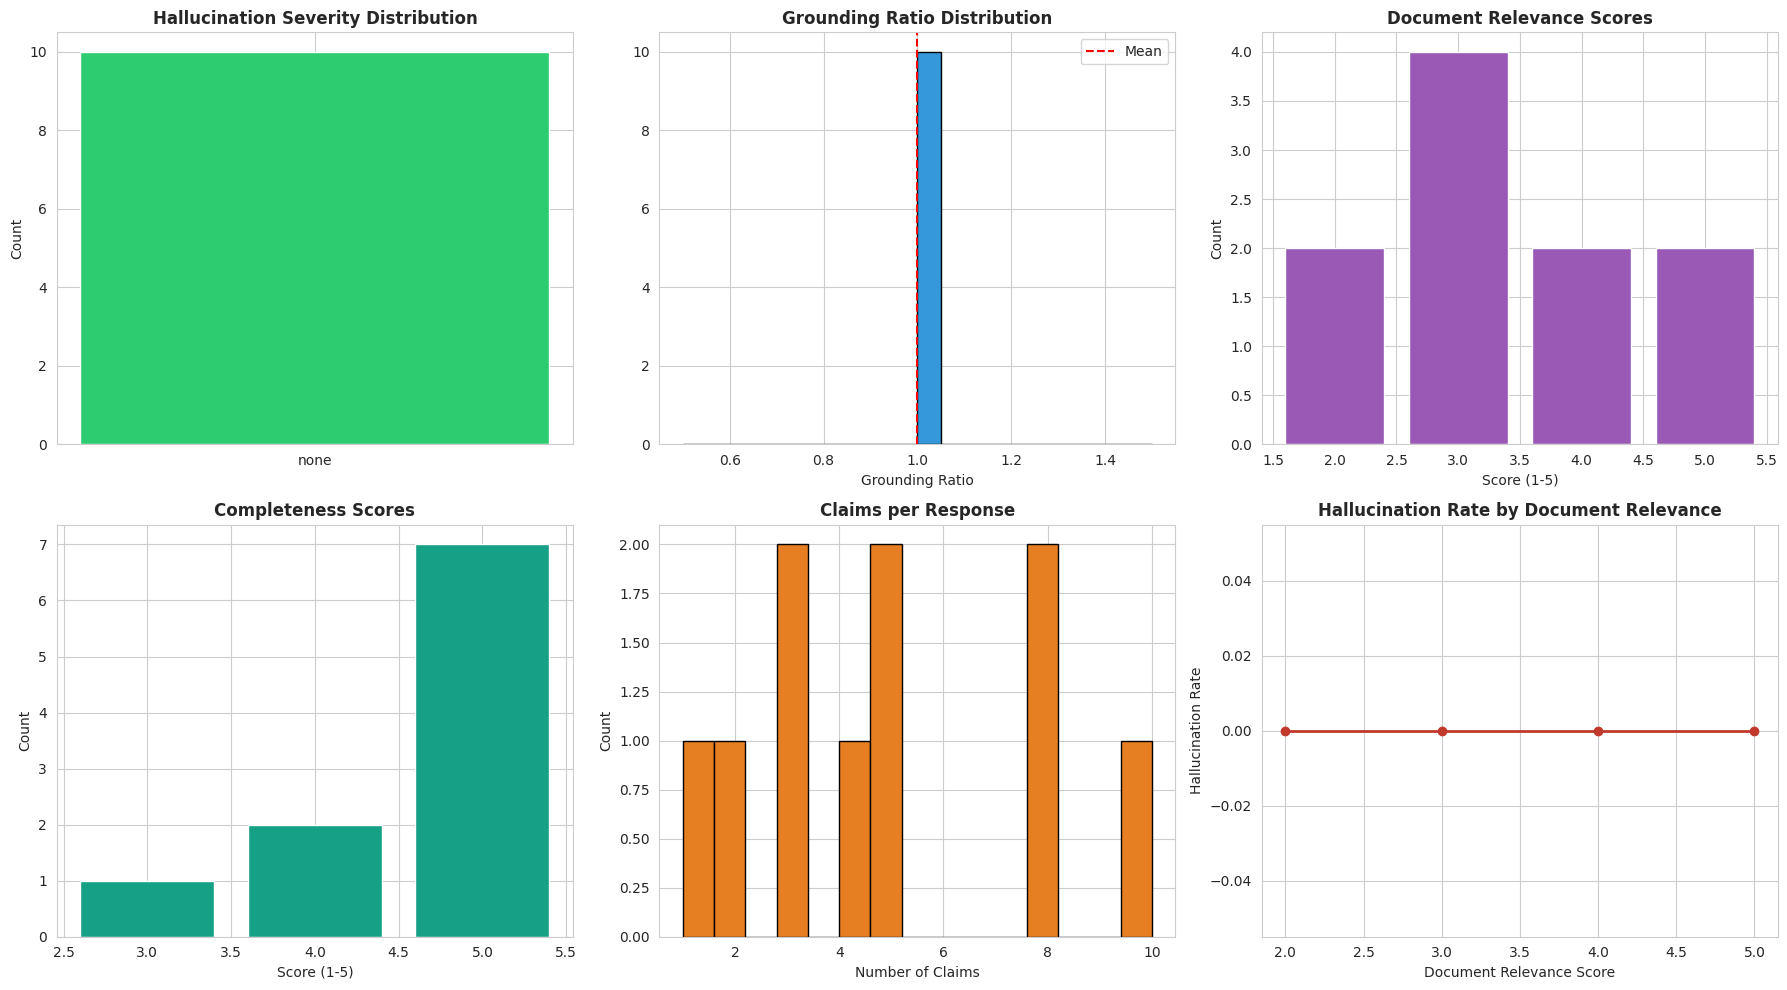


💾 Saved visualization: conecta_evaluation_results.png


In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Hallucination Severity
severity_counts = successful_results['hall_severity'].value_counts()
colors = {'none': '#2ecc71', 'minor': '#f39c12', 'major': '#e67e22', 'critical': '#e74c3c'}
bar_colors = [colors.get(x, '#95a5a6') for x in severity_counts.index]
axes[0, 0].bar(severity_counts.index, severity_counts.values, color=bar_colors)
axes[0, 0].set_title('Hallucination Severity Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')

# 2. Grounding Ratio Distribution
axes[0, 1].hist(successful_results['hall_grounding_ratio'], bins=20, color='#3498db', edgecolor='black')
axes[0, 1].axvline(successful_results['hall_grounding_ratio'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 1].set_title('Grounding Ratio Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Grounding Ratio')
axes[0, 1].legend()

# 3. Document Relevance Scores
rel_counts = successful_results['doc_relevance_score'].value_counts().sort_index()
axes[0, 2].bar(rel_counts.index, rel_counts.values, color='#9b59b6')
axes[0, 2].set_title('Document Relevance Scores', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Score (1-5)')
axes[0, 2].set_ylabel('Count')

# 4. Completeness Scores
comp_counts = successful_results['comp_completeness_score'].value_counts().sort_index()
axes[1, 0].bar(comp_counts.index, comp_counts.values, color='#16a085')
axes[1, 0].set_title('Completeness Scores', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Score (1-5)')
axes[1, 0].set_ylabel('Count')

# 5. Claims per Response
axes[1, 1].hist(successful_results['hall_total_claims'], bins=15, color='#e67e22', edgecolor='black')
axes[1, 1].set_title('Claims per Response', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Claims')
axes[1, 1].set_ylabel('Count')

# 6. Hallucination vs Document Relevance
hall_vs_rel = successful_results.groupby('doc_relevance_score')['hall_hallucination_detected'].mean()
axes[1, 2].plot(hall_vs_rel.index, hall_vs_rel.values, marker='o', linewidth=2, color='#c0392b')
axes[1, 2].set_title('Hallucination Rate by Document Relevance', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Document Relevance Score')
axes[1, 2].set_ylabel('Hallucination Rate')
axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig('conecta_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Saved visualization: conecta_evaluation_results.png")

### 4.5 Save Results

In [19]:
# from datetime import datetime

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# # Save full results
# output_file = f'conecta_evaluation_results_{timestamp}.csv'
# results_df.to_csv(output_file, index=False)
# print(f"✅ Saved full results: {output_file}")

# # Save critical hallucinations separately
# if len(critical_hallucinations) > 0:
#     critical_file = f'critical_hallucinations_{timestamp}.csv'
#     critical_hallucinations.to_csv(critical_file, index=False)
#     print(f"✅ Saved critical hallucinations: {critical_file}")

# # Save summary report
# summary_report = {
#     'timestamp': timestamp,
#     'total_conversations': len(results_df),
#     'successful_evaluations': results_df['success'].sum(),
#     'hallucination_rate': float(hallucination_rate),
#     'critical_hallucinations': int(len(critical_hallucinations)),
#     'mean_grounding_ratio': float(successful_results['hall_grounding_ratio'].mean()),
#     'mean_relevance_score': float(successful_results['doc_relevance_score'].mean()),
#     'mean_completeness_score': float(successful_results['comp_completeness_score'].mean()),
#     'unnecessary_clarifications': int(successful_results['comp_unnecessary_clarification'].sum())
# }

# import json
# summary_file = f'evaluation_summary_{timestamp}.json'
# with open(summary_file, 'w') as f:
#     json.dump(summary_report, f, indent=2)
# print(f"✅ Saved summary: {summary_file}")

## 5. Deep Dive: Individual Conversation Analysis

In [20]:
def display_conversation_analysis(session_id: str):
    """Display detailed analysis for a specific conversation"""
    
    # Get conversation data
    conv_data = conversation_df[conversation_df['sessionId'] == session_id].iloc[0]
    
    # Get evaluation results
    eval_data = results_df[results_df['session_id'] == session_id].iloc[0]
    
    print("="*100)
    print(f"CONVERSATION ANALYSIS: {session_id}")
    print("="*100)
    
    print("\n📝 USER QUESTION:")
    print("-"*100)
    print(conv_data['user_question'])
    
    print("\n🤖 CONECTA'S RESPONSE:")
    print("-"*100)
    print(conv_data['ai_response'])
    
    print("\n📚 DOCUMENTS USED:")
    print("-"*100)
    docs = conv_data['all_documents'][:500]
    print(docs + "..." if len(conv_data['all_documents']) > 500 else docs)
    
    print("\n🔍 EVALUATION RESULTS:")
    print("="*100)
    
    if eval_data['success']:
        print("\n🚨 HALLUCINATION:")
        print(f"   Detected: {eval_data['hall_hallucination_detected']}")
        print(f"   Severity: {eval_data['hall_severity']}")
        print(f"   Type: {eval_data['hall_hallucination_type']}")
        print(f"   Grounding: {eval_data['hall_grounding_ratio']:.1%}")
        print(f"   Assessment: {eval_data['hall_overall_assessment']}")
        
        print("\n📊 DOCUMENT RELEVANCE:")
        print(f"   Score: {eval_data['doc_relevance_score']}/5")
        print(f"   Has Answer: {eval_data['doc_has_answer']}")
        
        print("\n✅ COMPLETENESS:")
        print(f"   Score: {eval_data['comp_completeness_score']}/5")
        print(f"   Used All Info: {eval_data['comp_used_all_relevant_info']}")
        print(f"   Unnecessary Clarification: {eval_data['comp_unnecessary_clarification']}")
    else:
        print(f"❌ Evaluation failed: {eval_data['error']}")
    
    print("\n" + "="*100)

# Example usage
if len(results_df) > 0:
    example_session = results_df.iloc[0]['session_id']
    display_conversation_analysis(example_session)

CONVERSATION ANALYSIS: 0100fd52-c9ce-47ad-8052-5704b3089a12

📝 USER QUESTION:
----------------------------------------------------------------------------------------------------
cliente quiere cancelar el paquete de servicios bolivar

🤖 CONECTA'S RESPONSE:
----------------------------------------------------------------------------------------------------
Para cancelar el paquete de servicios de Seguros Bolívar, el cliente debe comunicarse directamente con Seguros Bolívar a través de los siguientes canales:

1. Teléfono en Bogotá: 3122122
2. Teléfono nacional: 018000123322
3. Desde el celular, de forma gratuita, marcando #322, ingresando con el número de cédula y seleccionando la opción correspondiente (generalmente opción 6 para seguros voluntarios).

Es importante que la cancelación la realice personalmente el cliente. Ten en cuenta que al cancelar algunos seguros, como el seguro de protección de pagos, no se devuelve el dinero de las primas ya cobradas.

Si necesitas más detalles o

## 6. Summary & Recommendations

Based on the evaluation results, generate recommendations for improving Conecta

In [21]:
print("="*100)
print("📋 SUMMARY & RECOMMENDATIONS")
print("="*100)

print("\n🎯 KEY FINDINGS:\n")

# 1. Hallucination issues
if hallucination_rate > 0.1:
    print("❌ HIGH HALLUCINATION RATE:")
    print(f"   - {hallucination_rate:.1%} of responses contain hallucinations")
    print(f"   - {len(critical_hallucinations)} critical cases detected")
    print("   → RECOMMENDATION: Review and improve grounding mechanisms")
else:
    print("✅ LOW HALLUCINATION RATE:")
    print(f"   - Only {hallucination_rate:.1%} of responses contain hallucinations")

# 2. Document relevance
mean_relevance = successful_results['doc_relevance_score'].mean()
if mean_relevance < 3.5:
    print("\n❌ POOR DOCUMENT RETRIEVAL:")
    print(f"   - Mean relevance score: {mean_relevance:.2f}/5")
    print("   → RECOMMENDATION: Improve document search and retrieval system")
else:
    print("\n✅ GOOD DOCUMENT RETRIEVAL:")
    print(f"   - Mean relevance score: {mean_relevance:.2f}/5")

# 3. Completeness
unnecessary_clarifications = successful_results['comp_unnecessary_clarification'].sum()
if unnecessary_clarifications > len(successful_results) * 0.2:
    print("\n⚠️  EXCESSIVE CLARIFICATION REQUESTS:")
    print(f"   - {unnecessary_clarifications} unnecessary clarifications ({unnecessary_clarifications/len(successful_results)*100:.1f}%)")
    print("   → RECOMMENDATION: Improve response generation to use available document info")

# 4. Grounding
low_grounding = (successful_results['hall_grounding_ratio'] < 0.8).sum()
if low_grounding > 0:
    print(f"\n⚠️  LOW GROUNDING IN {low_grounding} CONVERSATIONS:")
    print("   → RECOMMENDATION: Enforce stricter adherence to source documents")

print("\n" + "="*100)
print("✅ ANALYSIS COMPLETE!")
print("="*100)

📋 SUMMARY & RECOMMENDATIONS

🎯 KEY FINDINGS:

✅ LOW HALLUCINATION RATE:
   - Only 0.0% of responses contain hallucinations

❌ POOR DOCUMENT RETRIEVAL:
   - Mean relevance score: 3.40/5
   → RECOMMENDATION: Improve document search and retrieval system

✅ ANALYSIS COMPLETE!


## 7. Deep Hallucination Analysis

Goes beyond basic detection to understand **WHY** Conecta hallucinates:
- **Root Cause Analysis**: Document length? Question quality? Missing information?
- **Pattern Detection**: When do hallucinations happen most?
- **Detailed Examples**: See exact claims to validate if evaluator is accurate or too strict
- **Correlations**: Statistical analysis of hallucination triggers

In [22]:
# Helper functions for deep analysis
import numpy as np

def calculate_text_metrics(text: str) -> dict:
    """Calculate metrics about text quality"""
    if not text or pd.isna(text):
        return {'length': 0, 'word_count': 0, 'is_vague': True}
    
    words = text.split()
    return {
        'length': len(text),
        'word_count': len(words),
        'is_vague': len(words) < 5
    }

def analyze_hallucination_patterns(conversations, results):
    """Analyze patterns in hallucinations - handles flattened result format"""
    analysis_rows = []
    
    for conv, result_dict in zip(conversations, results):
        if not result_dict.get('success'):
            continue
        
        # Calculate question/response metrics
        q_metrics = calculate_text_metrics(conv.user_question)
        r_metrics = calculate_text_metrics(conv.ai_response)
        
        # Documents is a STRING (all docs concatenated), not a list
        # Split by document separator to count individual documents
        if conv.documents:
            # Count documents by splitting on the separator pattern
            # Format: "Documento 123.0: content\n\nDocumento 456.0: content"
            import re
            doc_pattern = r'Documento \d+\.0:'
            doc_matches = re.findall(doc_pattern, conv.documents)
            doc_count = len(doc_matches) if doc_matches else 1  # At least 1 if there's content
            
            # Total length of all documents combined
            total_doc_length = len(conv.documents)
            avg_doc_length = total_doc_length / doc_count if doc_count > 0 else 0
        else:
            doc_count = 0
            total_doc_length = 0
            avg_doc_length = 0
        
        row = {
            'session_id': conv.session_id,
            
            # Hallucination data (from flattened format)
            'has_hallucination': result_dict.get('hall_hallucination_detected', False),
            'severity': result_dict.get('hall_severity', 'none'),
            'grounding_ratio': result_dict.get('hall_grounding_ratio', 1.0),
            'hallucination_type': result_dict.get('hall_hallucination_type', 'none'),
            
            # Question/response metrics
            'q_length': q_metrics['length'],
            'q_word_count': q_metrics['word_count'],
            'q_is_vague': q_metrics['is_vague'],
            'r_length': r_metrics['length'],
            'r_word_count': r_metrics['word_count'],
            
            # Document metrics
            'doc_count': doc_count,
            'total_doc_length': total_doc_length,
            'avg_doc_length': avg_doc_length,
            
            # Document relevance data (from flattened format)
            'doc_has_answer': result_dict.get('doc_has_answer', False),
            'doc_relevance_score': result_dict.get('doc_relevance_score', 0),
            
            # Completeness data (from flattened format)
            'completeness_score': result_dict.get('comp_completeness_score', 0),
            'used_all_info': result_dict.get('comp_used_all_relevant_info', False),
            
            # Full text for review
            'user_question': conv.user_question,
            'ai_response': conv.ai_response,
            'evidence': result_dict.get('hall_evidence', []),
            'reasoning': result_dict.get('hall_overall_assessment', ''),
        }
        analysis_rows.append(row)
    
    return pd.DataFrame(analysis_rows)

print("✅ Helper functions loaded (FIXED for flattened format + string documents)")

✅ Helper functions loaded (FIXED for flattened format + string documents)


In [23]:
# Deep Analysis: Reuse 10 already-evaluated + evaluate 10 new (20 total, ~$0.04 cost)
# With progress tracking and checkpoint saving

import json
from pathlib import Path
from tqdm.auto import tqdm
import time

print("🔍 DEEP HALLUCINATION ANALYSIS")
print("="*100)
print()
print("Strategy: Reuse 10 already-evaluated + evaluate 10 new conversations")
print("   - 10 already evaluated (Section 4): $0.00")
print("   - 10 new conversations: ~$0.04")
print("   - Total: 20 conversations for pattern detection")
print()

# Checkpoint file
checkpoint_file = Path("deep_analysis_checkpoint.json")

# Part 1: Reuse the 10 already-evaluated conversations
print("✅ Reusing 10 already-evaluated conversations (no cost)")
reused_conversations = conversations_to_evaluate  # From Section 4
reused_results = [r.to_dict() for r in evaluation_results]  # Already have results

# Part 2: Select 10 NEW conversations (indices 10-20)
print("📝 Selecting 10 NEW conversations to evaluate...")
new_start = 10
new_end = min(20, len(conversation_df_copy))
new_sample_df = conversation_df_copy.iloc[new_start:new_end].copy()

new_conversations = []
for idx, row in new_sample_df.iterrows():
    conv = ConversationData(
        session_id=row['sessionId'],
        user_question=row['user_question'],
        ai_response=row['ai_response'],
        documents=row['all_documents'],
        escalated=row.get('need_expert', False)
    )
    new_conversations.append(conv)

print(f"   Selected {len(new_conversations)} new conversations")
print()

# Part 3: Load checkpoint if exists
new_results = []
evaluated_sessions = set()

if checkpoint_file.exists():
    print("📂 Found checkpoint file - loading previous progress...")
    with open(checkpoint_file, 'r') as f:
        checkpoint_data = json.load(f)
        new_results = checkpoint_data.get('results', [])
        evaluated_sessions = set(checkpoint_data.get('evaluated_sessions', []))
    print(f"   ✅ Loaded {len(new_results)} previously evaluated conversations")
    print()

# Part 4: Evaluate ONLY new ones that weren't already done
remaining_conversations = [c for c in new_conversations if c.session_id not in evaluated_sessions]

if len(remaining_conversations) == 0:
    print("✅ All new conversations already evaluated!")
else:
    print(f"🤖 Evaluating {len(remaining_conversations)} NEW conversations...")
    print(f"   Cost: ~${len(remaining_conversations) * 0.0037:.2f}")
    print(f"   Progress will be saved after each conversation")
    print()
    
    # Progress bar
    pbar = tqdm(remaining_conversations, desc="Evaluating", unit="conv")
    
    for conv in pbar:
        session_short = conv.session_id[:30]
        pbar.set_description(f"Evaluating {session_short}")
        
        try:
            # Add timeout tracking
            start_time = time.time()
            result = orchestrator.evaluate_conversation(conv, run_verification=True)
            elapsed = time.time() - start_time
            
            result_dict = result.to_dict()
            new_results.append(result_dict)
            evaluated_sessions.add(conv.session_id)
            
            # Save checkpoint after each success
            with open(checkpoint_file, 'w') as f:
                json.dump({
                    'results': new_results,
                    'evaluated_sessions': list(evaluated_sessions),
                    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
                }, f)
            
            pbar.set_postfix({'status': '✅', 'time': f'{elapsed:.1f}s'})
            
        except Exception as e:
            error_msg = str(e)[:50]
            pbar.set_postfix({'status': '❌', 'error': error_msg})
            print(f"\n❌ Error on {session_short}: {error_msg}")
            continue
    
    pbar.close()
    print()

# Part 5: Combine both sets
print("🔗 Combining results...")
deep_conversations = reused_conversations + [c for c in new_conversations if c.session_id in evaluated_sessions]
deep_results = reused_results + new_results

print(f"   Reused: {len(reused_conversations)} conversations")
print(f"   New: {len(new_results)} conversations")
print(f"   Total: {len(deep_conversations)} conversations")
print()

# Part 6: Build analysis dataframe
analysis_df = analyze_hallucination_patterns(deep_conversations, deep_results)
print(f"✅ Analysis complete: {len(analysis_df)} conversations analyzed")
print()

# Clean up checkpoint file when done
if checkpoint_file.exists() and len(remaining_conversations) == 0:
    checkpoint_file.unlink()
    print("🗑️  Removed checkpoint file (all evaluations complete)")

🔍 DEEP HALLUCINATION ANALYSIS

Strategy: Reuse 10 already-evaluated + evaluate 10 new conversations
   - 10 already evaluated (Section 4): $0.00
   - 10 new conversations: ~$0.04
   - Total: 20 conversations for pattern detection

✅ Reusing 10 already-evaluated conversations (no cost)
📝 Selecting 10 NEW conversations to evaluate...
   Selected 10 new conversations

📂 Found checkpoint file - loading previous progress...
   ✅ Loaded 10 previously evaluated conversations

✅ All new conversations already evaluated!
🔗 Combining results...
   Reused: 10 conversations
   New: 10 conversations
   Total: 20 conversations

✅ Analysis complete: 20 conversations analyzed

🗑️  Removed checkpoint file (all evaluations complete)


**⚠️ IMPORTANT: Timeout Protection**

The evaluation now includes timeout protection to prevent hanging:
- **Default timeout**: 120 seconds (2 minutes) per API call
- **Auto-retry**: 3 attempts with exponential backoff
- **Graceful failure**: Continues to next conversation if one times out

If you see timeouts, you can increase the timeout in the config:
```python
config.api_timeout = 180  # 3 minutes
```

### Check Progress / Resume

If the evaluation gets stuck or you need to restart, run this cell to check saved progress:

In [24]:
# Check checkpoint progress
import json
from pathlib import Path

checkpoint_file = Path("deep_analysis_checkpoint.json")

if checkpoint_file.exists():
    with open(checkpoint_file, 'r') as f:
        checkpoint_data = json.load(f)
    
    print("📂 CHECKPOINT STATUS")
    print("="*80)
    print(f"   Saved at: {checkpoint_data.get('timestamp', 'unknown')}")
    print(f"   Completed evaluations: {len(checkpoint_data.get('results', []))}")
    print(f"   Remaining: {10 - len(checkpoint_data.get('results', []))}")
    print()
    print("✅ You can re-run Cell 38 to continue from where you left off")
    print("   It will skip already-evaluated conversations")
else:
    print("📂 No checkpoint file found")
    print("   Either you haven't started or completed all evaluations")

📂 No checkpoint file found
   Either you haven't started or completed all evaluations


In [25]:
print("="*100)
print("CORRELATION ANALYSIS: What Causes Hallucinations?")
print("="*100 + "\n")

hall_df = analysis_df[analysis_df['has_hallucination'] == True]
clean_df = analysis_df[analysis_df['has_hallucination'] == False]

if len(hall_df) > 0:
    print(f"📊 Hallucinations: {len(hall_df)}/{len(analysis_df)} ({len(hall_df)/len(analysis_df)*100:.1f}%)\n")
    
    # Compare numerical factors
    factors = [
        ('Avg Document Length (chars)', 'avg_doc_length'),
        ('Total Document Length (chars)', 'total_doc_length'),
        ('Number of Documents', 'doc_count'),
        ('Question Word Count', 'q_word_count'),
        ('Response Word Count', 'r_word_count'),
        ('Doc Relevance Score (1-5)', 'doc_relevance_score'),
        ('Completeness Score (1-5)', 'completeness_score'),
    ]
    
    print("🔍 Comparing Hallucination vs Clean Cases:\n")
    for label, col in factors:
        if col not in hall_df.columns or col not in clean_df.columns:
            continue
            
        hall_avg = hall_df[col].mean()
        clean_avg = clean_df[col].mean()
        diff_pct = ((hall_avg - clean_avg) / clean_avg * 100) if clean_avg > 0 else 0
        
        # Flag significant differences
        if abs(diff_pct) > 50:
            indicator = "🔴 MAJOR"
        elif abs(diff_pct) > 20:
            indicator = "🟡 NOTABLE"
        else:
            indicator = "✅"
        
        print(f"{indicator} {label}:")
        print(f"   With Hallucination: {hall_avg:,.1f}")
        print(f"   Without: {clean_avg:,.1f}")
        print(f"   Difference: {diff_pct:+.1f}%\n")
    
    # Boolean factors
    print("📊 Boolean Factors:\n")
    
    hall_has_answer = hall_df['doc_has_answer'].sum() / len(hall_df) * 100 if len(hall_df) > 0 else 0
    clean_has_answer = clean_df['doc_has_answer'].sum() / len(clean_df) * 100 if len(clean_df) > 0 else 0
    
    print(f"{'🔴' if hall_has_answer > 50 else '✅'} Documents Contain Answer:")
    print(f"   With Hallucination: {hall_has_answer:.1f}%")
    print(f"   Without: {clean_has_answer:.1f}%\n")
    
    hall_vague = hall_df['q_is_vague'].sum() / len(hall_df) * 100 if len(hall_df) > 0 else 0
    clean_vague = clean_df['q_is_vague'].sum() / len(clean_df) * 100 if len(clean_df) > 0 else 0
    
    print(f"{'🟡' if abs(hall_vague - clean_vague) > 20 else '✅'} Vague Questions (<5 words):")
    print(f"   With Hallucination: {hall_vague:.1f}%")
    print(f"   Without: {clean_vague:.1f}%\n")
    
    # Key insights
    print("="*100)
    print("💡 KEY INSIGHTS:")
    print("="*100 + "\n")
    
    if hall_has_answer > 70:
        print("⚠️  CRITICAL: Most hallucinations happen DESPITE having the answer in documents!")
        print("   → This suggests the AI is not properly using available information\n")
    
    if abs(diff_pct) > 50:  # Using last calculated diff_pct
        print(f"⚠️  {label} shows major difference between hallucination and clean cases")
        print(f"   → This may be a key factor triggering hallucinations\n")
    
    # Severity distribution
    print("📉 Severity Distribution:")
    severity_counts = hall_df['severity'].value_counts()
    for sev, count in severity_counts.items():
        print(f"   {sev.upper()}: {count} ({count/len(hall_df)*100:.1f}%)")
        
else:
    print("✅ No hallucinations detected in this sample")
    print(f"   Analyzed: {len(analysis_df)} conversations")
    print(f"   Mean document count: {analysis_df['doc_count'].mean():.1f}")
    print(f"   Mean relevance score: {analysis_df['doc_relevance_score'].mean():.1f}/5")
    print(f"   Mean completeness score: {analysis_df['completeness_score'].mean():.1f}/5")

CORRELATION ANALYSIS: What Causes Hallucinations?

📊 Hallucinations: 5/20 (25.0%)

🔍 Comparing Hallucination vs Clean Cases:

✅ Avg Document Length (chars):
   With Hallucination: 1,561.0
   Without: 1,755.5
   Difference: -11.1%

✅ Total Document Length (chars):
   With Hallucination: 2,915.8
   Without: 3,121.5
   Difference: -6.6%

✅ Number of Documents:
   With Hallucination: 2.2
   Without: 2.0
   Difference: +10.0%

🟡 NOTABLE Question Word Count:
   With Hallucination: 6.8
   Without: 9.7
   Difference: -29.7%

✅ Response Word Count:
   With Hallucination: 167.4
   Without: 142.3
   Difference: +17.6%

✅ Doc Relevance Score (1-5):
   With Hallucination: 3.0
   Without: 3.5
   Difference: -15.1%

✅ Completeness Score (1-5):
   With Hallucination: 4.6
   Without: 4.6
   Difference: +0.0%

📊 Boolean Factors:

🔴 Documents Contain Answer:
   With Hallucination: 60.0%
   Without: 66.7%

✅ Vague Questions (<5 words):
   With Hallucination: 20.0%
   Without: 13.3%

💡 KEY INSIGHTS:

📉 Sev

In [26]:
hallucination_cases = analysis_df[analysis_df['has_hallucination'] == True].copy()

if len(hallucination_cases) > 0:
    severity_order = {'critical': 0, 'major': 1, 'minor': 2}
    hallucination_cases['severity_rank'] = hallucination_cases['severity'].map(severity_order)
    hallucination_cases = hallucination_cases.sort_values('severity_rank')
    
    # Show first 5 examples
    for idx, row in hallucination_cases.head(5).iterrows():
        print("\n" + "="*100)
        print(f"Severity: {row['severity'].upper()} | Grounding: {row['grounding_ratio']*100:.0f}%")
        print("="*100)
        
        print(f"\n📊 Context: {row['doc_count']:.0f} docs ({row['avg_doc_length']:,.0f} chars avg), relevance {row['doc_relevance_score']:.0f}/5")
        print(f"   Has answer: {'✅ Yes' if row['doc_has_answer'] else '❌ No'}")
        
        print(f"\n❓ USER: {row['user_question']}")
        print(f"\n🤖 CONECTA: {row['ai_response'][:300]}...")
        
        print(f"\n💭 EVALUATOR: {row['reasoning'][:200]}..." if row['reasoning'] else "")
        
        if row['evidence'] and len(row['evidence']) > 0:
            print(f"\n🔍 Hallucinated Claims:")
            for i, ev in enumerate(row['evidence'][:3], 1):
                if isinstance(ev, dict):
                    print(f"   {i}. \"{ev.get('claim', 'Unknown')[:100]}\"")
                    print(f"      Issue: {ev.get('explanation', 'N/A')[:100]}")
        
        print("\n❓ Is this actually wrong, or is the evaluator too strict?")
        print("-"*100)
else:
    print("No hallucination examples found")


Severity: MAJOR | Grounding: 100%

📊 Context: 3 docs (1,192 chars avg), relevance 4/5
   Has answer: ✅ Yes

❓ USER: COMO FUNCIONA Y QUE REQUISITOS TIENE

🤖 CONECTA: El preaprobador digital es una herramienta diseñada para darte una viabilidad inicial de crédito basada en las políticas del banco y tu capacidad de pago. Funciona evaluando tu información y aplicando los criterios definidos por las áreas de riesgo y líneas de negocio para productos como consumo, li...

💭 EVALUATOR: All claims are supported by the provided documents. Therefore, there are no hallucinations....

🔍 Hallucinated Claims:
   1. "El preaprobador digital es una herramienta diseñada para darte una viabilidad inicial de crédito bas"
      Issue: This claim is supported by Document 627.0.
   2. "Funciona evaluando tu información y aplicando los criterios definidos por las áreas de riesgo y líne"
      Issue: This claim is supported by Document 9522.0 and 627.0
   3. "La consulta que haces en esta herramienta tiene un

In [27]:
# Cell: Detailed examination of the 2 hallucinations
print("="*100)
print("DETAILED EXAMINATION: 2 Detected Hallucinations")
print("="*100)

hallucinations = results_df[results_df['hall_hallucination_detected'] == True]

for i, (idx, row) in enumerate(hallucinations.iterrows(), 1):
    conv_data = conversation_df[conversation_df['sessionId']==row['session_id']].iloc[0]

    print(f"\n{'='*100}")
    print(f"CASE {i}/2: {row['hall_severity'].upper()}")
    print(f"{'='*100}")

    print(f"\n❓ USER QUESTION:")
    print(conv_data['user_question'])

    print(f"\n🤖 CONECTA RESPONSE:")
    print(conv_data['ai_response'])

    print(f"\n📊 CONTEXT:")
    print(f"   Document relevance: {row['doc_relevance_score']}/5")
    print(f"   Docs have answer: {'✅ Yes' if row['doc_has_answer'] else '❌ No'}")
    print(f"   Grounding ratio: {row['hall_grounding_ratio']:.0%}")
    print(f"   Completeness: {row['comp_completeness_score']}/5")

    print(f"\n💭 EVALUATOR REASONING:")
    print(row['hall_overall_assessment'])

    print(f"\n🔍 EVIDENCE:")
    print(row['hall_evidence'])

    print(f"\n❓ YOUR VALIDATION:")
    print("   [ ] This is actually a hallucination")
    print("   [ ] This is reasonable inference - evaluator too strict")
    print("   [ ] Unclear - need more context")

DETAILED EXAMINATION: 2 Detected Hallucinations


In [28]:
# Save detailed results for further analysis
output_file = "hallucination_analysis_detailed.csv"
analysis_df.to_csv(output_file, index=False)

print(f"💾 Saved detailed analysis to: {output_file}")
print()
print("Columns in CSV:")
print("  - session_id, has_hallucination, severity, grounding_ratio")
print("  - q_length, q_word_count, q_is_vague")
print("  - r_length, r_word_count")
print("  - doc_count, avg_doc_length, doc_relevance_score, doc_has_answer")
print("  - user_question, ai_response, evidence, reasoning")
print()
print("Use this for custom analysis in Excel or Python")

💾 Saved detailed analysis to: hallucination_analysis_detailed.csv

Columns in CSV:
  - session_id, has_hallucination, severity, grounding_ratio
  - q_length, q_word_count, q_is_vague
  - r_length, r_word_count
  - doc_count, avg_doc_length, doc_relevance_score, doc_has_answer
  - user_question, ai_response, evidence, reasoning

Use this for custom analysis in Excel or Python


## 8. Follow-Up Question Analysis

**Purpose:** Understand if follow-up questions improve conversation quality

**Key Questions:**
1. Do follow-up conversations have fewer hallucinations?
2. Does Conecta asking clarification questions lead to better answers?
3. Are multi-turn conversations more likely to escalate?

In [29]:
# Analyze multi-turn vs single-turn conversations
print("="*100)
print("FOLLOW-UP QUESTION ANALYSIS")
print("="*100 + "\n")

# Check if turn fields exist, if not, assume all are single-turn
if 'turn_number' not in conversation_df.columns:
    print("⚠️  WARNING: Turn information not available in current dataset")
    print("   To enable this analysis, re-run cells 1-11 to reload data with conversation history")
    print()
    print("   The new ETL pipeline adds: prev_user_question, prev_ai_response, turn_number, total_turns")
    print()
    print("   For now, assuming all conversations are single-turn...")
    conversation_df['turn_number'] = 1
    conversation_df['total_turns'] = 1
    print()

# Add turn information to analysis_df
conv_turn_info = conversation_df[['sessionId', 'turn_number', 'total_turns']].copy()
analysis_with_turns = analysis_df.merge(
    conv_turn_info, 
    left_on='session_id', 
    right_on='sessionId', 
    how='left'
)

# Classify conversations
analysis_with_turns['is_followup'] = analysis_with_turns['turn_number'] > 1
analysis_with_turns['is_multi_turn'] = analysis_with_turns['total_turns'] > 1

single_turn = analysis_with_turns[analysis_with_turns['is_multi_turn'] == False]
multi_turn = analysis_with_turns[analysis_with_turns['is_multi_turn'] == True]
followup_turns = analysis_with_turns[analysis_with_turns['is_followup'] == True]

print(f"📊 Conversation Types:")
print(f"   Single-turn: {len(single_turn)} ({len(single_turn)/len(analysis_with_turns)*100:.1f}%)")
print(f"   Multi-turn: {len(multi_turn)} ({len(multi_turn)/len(analysis_with_turns)*100:.1f}%)")
print(f"   Follow-up turns (turn 2+): {len(followup_turns)}")
print()

if len(multi_turn) == 0:
    print("📍 No multi-turn conversations found in this sample")
    print("   All conversations are single-turn (one question → one response)")
else:
    # Compare hallucination rates
    print("🚨 HALLUCINATION RATES:")
    print(f"   Single-turn: {single_turn['has_hallucination'].sum()}/{len(single_turn)} ({single_turn['has_hallucination'].mean()*100:.1f}%)")
    print(f"   Multi-turn: {multi_turn['has_hallucination'].sum()}/{len(multi_turn)} ({multi_turn['has_hallucination'].mean()*100:.1f}%)")
    if len(followup_turns) > 0:
        print(f"   Follow-up turns only: {followup_turns['has_hallucination'].sum()}/{len(followup_turns)} ({followup_turns['has_hallucination'].mean()*100:.1f}%)")
    print()

    # Quality metrics comparison
    print("📈 QUALITY METRICS:")
    print()
    print("Document Relevance (1-5):")
    print(f"   Single-turn: {single_turn['doc_relevance_score'].mean():.2f}")
    print(f"   Multi-turn: {multi_turn['doc_relevance_score'].mean():.2f}")
    print()

    print("Completeness (1-5):")
    print(f"   Single-turn: {single_turn['completeness_score'].mean():.2f}")
    print(f"   Multi-turn: {multi_turn['completeness_score'].mean():.2f}")
    print()

    print("Grounding Ratio:")
    print(f"   Single-turn: {single_turn['grounding_ratio'].mean():.2%}")
    print(f"   Multi-turn: {multi_turn['grounding_ratio'].mean():.2%}")
    print()

    # Statistical significance indicator
    hall_diff = abs(single_turn['has_hallucination'].mean() - multi_turn['has_hallucination'].mean())
    if hall_diff > 0.15:  # >15 percentage points
        print("⚠️  SIGNIFICANT: Multi-turn conversations show notably different hallucination rate")
    elif hall_diff > 0.10:
        print("🟡 MODERATE: Some difference in hallucination rates")
    else:
        print("✅ Similar hallucination rates between single and multi-turn conversations")


FOLLOW-UP QUESTION ANALYSIS

📊 Conversation Types:
   Single-turn: 20 (100.0%)
   Multi-turn: 0 (0.0%)
   Follow-up turns (turn 2+): 0

📍 No multi-turn conversations found in this sample
   All conversations are single-turn (one question → one response)


### 8.2 Clarification Question Effectiveness

Does Conecta asking clarification lead to better final answers?

In [30]:
# Detect if Conecta asked a clarification question
def conecta_asked_clarification(response: str) -> bool:
    """Detect if Conecta asked for clarification"""
    if not response or pd.isna(response):
        return False
    
    # Look for question marks and clarification phrases
    has_question = '?' in response
    
    clarification_phrases = [
        '¿podrías', '¿puedes', '¿me podrías', '¿necesitas',
        'para ayudarte mejor', 'necesito que', 'cuál específicamente',
        'qué tipo de', 'podrías especificar', 'dame más detalles'
    ]
    
    response_lower = response.lower()
    has_clarification = any(phrase in response_lower for phrase in clarification_phrases)
    
    return has_question and has_clarification

# Apply detection to previous AI responses in multi-turn conversations
followup_analysis = followup_turns.copy()
if len(followup_analysis) > 0:
    # For follow-up turns, check if previous Conecta response asked a question
    # We need to get prev_ai_response from the conversation data
    
    print("="*100)
    print("CLARIFICATION QUESTION EFFECTIVENESS")
    print("="*100 + "\n")
    
    # Count how many follow-ups we have
    print(f"📊 Follow-up turns analyzed: {len(followup_analysis)}")
    print()
    
    # Check if we can detect clarification patterns
    # For now, we'll analyze the structure of follow-up questions
    
    # Short questions (likely clarifications to previous Conecta question)
    short_followups = followup_analysis[followup_analysis['q_word_count'] < 7]
    normal_followups = followup_analysis[followup_analysis['q_word_count'] >= 7]
    
    print(f"🔍 Follow-up Question Types:")
    print(f"   Short questions (<7 words): {len(short_followups)} - likely answering Conecta's clarification")
    print(f"   Normal questions (≥7 words): {len(normal_followups)} - new topic or detailed follow-up")
    print()
    
    if len(short_followups) > 0:
        print("📈 Short Follow-up Quality (likely clarifications):")
        print(f"   Hallucination rate: {short_followups['has_hallucination'].mean()*100:.1f}%")
        print(f"   Avg relevance: {short_followups['doc_relevance_score'].mean():.2f}/5")
        print(f"   Avg completeness: {short_followups['completeness_score'].mean():.2f}/5")
        print()
    
    if len(normal_followups) > 0:
        print("📈 Normal Follow-up Quality:")
        print(f"   Hallucination rate: {normal_followups['has_hallucination'].mean()*100:.1f}%")
        print(f"   Avg relevance: {normal_followups['doc_relevance_score'].mean():.2f}/5")
        print(f"   Avg completeness: {normal_followups['completeness_score'].mean():.2f}/5")
        print()
    
    # Compare with first-turn conversations
    first_turns = analysis_with_turns[analysis_with_turns['turn_number'] == 1]
    
    print("📊 COMPARISON: Follow-ups vs First Turn")
    print(f"   First turn hallucination rate: {first_turns['has_hallucination'].mean()*100:.1f}%")
    print(f"   Follow-up hallucination rate: {followup_analysis['has_hallucination'].mean()*100:.1f}%")
    print()
    
    diff = first_turns['has_hallucination'].mean() - followup_analysis['has_hallucination'].mean()
    if diff > 0.15:
        print("✅ FINDING: Follow-ups have SIGNIFICANTLY FEWER hallucinations")
        print("   → Clarification questions are effective!")
    elif diff < -0.15:
        print("⚠️  FINDING: Follow-ups have MORE hallucinations")
        print("   → Multi-turn conversations may introduce confusion")
    else:
        print("📍 FINDING: Similar hallucination rates")
        print("   → Follow-ups neither help nor hurt significantly")
else:
    print("No follow-up conversations found in this sample")


No follow-up conversations found in this sample


## 9. Blame Analysis: User vs Conecta

**Purpose:** Determine who is responsible when conversations go wrong

**Analysis Framework:**
- **User's Fault:** Vague/unclear question, insufficient details, off-topic
- **Conecta's Fault:** Hallucination, wrong answer despite having info, unnecessary escalation
- **Both:** Unclear question + Conecta didn't ask for clarification
- **Neither:** Good question, good answer (no issues)

In [31]:
# Blame assignment logic
def assign_blame(row):
    """
    Determine who is at fault when things go wrong
    
    Returns: 'user', 'conecta', 'both', or 'neither'
    """
    # Define problem indicators
    has_hallucination = row['has_hallucination']
    vague_question = row['q_is_vague']
    doc_has_answer = row['doc_has_answer']
    doc_relevance_low = row['doc_relevance_score'] < 3
    completeness_low = row['completeness_score'] < 3
    unnecessary_clarification = row.get('used_all_info', True) == False  # Asked for clarification when had info
    
    # User fault conditions
    user_fault_conditions = [
        vague_question and doc_relevance_low,  # Vague question leads to irrelevant docs
    ]
    
    # Conecta fault conditions
    conecta_fault_conditions = [
        has_hallucination and doc_has_answer,  # Hallucinated despite having answer
        not has_hallucination and doc_has_answer and completeness_low,  # Had answer but gave incomplete response
        unnecessary_clarification  # Asked for clarification unnecessarily
    ]
    
    # Both fault
    both_fault_conditions = [
        vague_question and has_hallucination,  # Vague question + hallucination (should have asked for clarification)
        vague_question and completeness_low  # Vague question + incomplete answer
    ]
    
    # Assign blame
    if any(both_fault_conditions):
        return 'both'
    elif any(conecta_fault_conditions):
        return 'conecta'
    elif any(user_fault_conditions):
        return 'user'
    else:
        return 'neither'  # No significant issues

# Apply blame assignment
analysis_df['blame'] = analysis_df.apply(assign_blame, axis=1)

print("="*100)
print("BLAME ANALYSIS: Who's Responsible When Things Go Wrong?")
print("="*100 + "\n")

# Overall distribution
print("📊 Overall Blame Distribution:")
blame_counts = analysis_df['blame'].value_counts()
for blame_type, count in blame_counts.items():
    pct = count / len(analysis_df) * 100
    print(f"   {blame_type.upper()}: {count} ({pct:.1f}%)")
print()

# Detailed breakdown by blame type
print("="*100)
print("DETAILED BREAKDOWN")
print("="*100 + "\n")

# User's fault cases
user_fault = analysis_df[analysis_df['blame'] == 'user']
if len(user_fault) > 0:
    print(f"👤 USER'S FAULT ({len(user_fault)} cases):")
    print(f"   - Vague questions: {user_fault['q_is_vague'].sum()}")
    print(f"   - Low doc relevance: {(user_fault['doc_relevance_score'] < 3).sum()}")
    print(f"   Example questions:")
    for q in user_fault['user_question'].head(3):
        print(f"      • {q[:80]}")
    print()

# Conecta's fault cases
conecta_fault = analysis_df[analysis_df['blame'] == 'conecta']
if len(conecta_fault) > 0:
    print(f"🤖 CONECTA'S FAULT ({len(conecta_fault)} cases):")
    print(f"   - Hallucinations with answer available: {(conecta_fault['has_hallucination'] & conecta_fault['doc_has_answer']).sum()}")
    print(f"   - Incomplete despite having info: {((conecta_fault['completeness_score'] < 3) & conecta_fault['doc_has_answer']).sum()}")
    print(f"   Severity of issues:")
    for severity, count in conecta_fault['severity'].value_counts().items():
        print(f"      • {severity}: {count}")
    print()

# Both fault cases
both_fault = analysis_df[analysis_df['blame'] == 'both']
if len(both_fault) > 0:
    print(f"⚖️  BOTH AT FAULT ({len(both_fault)} cases):")
    print(f"   - Vague question + hallucination: {(both_fault['q_is_vague'] & both_fault['has_hallucination']).sum()}")
    print(f"   - Vague question + incomplete answer: {(both_fault['q_is_vague'] & (both_fault['completeness_score'] < 3)).sum()}")
    print(f"   → Conecta should have asked for clarification but didn't")
    print()

# Neither fault (success cases)
neither_fault = analysis_df[analysis_df['blame'] == 'neither']
if len(neither_fault) > 0:
    print(f"✅ NEITHER (Success cases: {len(neither_fault)} / {len(analysis_df)} = {len(neither_fault)/len(analysis_df)*100:.1f}%)")
    print(f"   - No hallucinations: {(~neither_fault['has_hallucination']).sum()}")
    print(f"   - Good completeness: {(neither_fault['completeness_score'] >= 4).sum()}")
    print(f"   - Good relevance: {(neither_fault['doc_relevance_score'] >= 4).sum()}")
    print()

# Key insight
print("="*100)
print("💡 KEY INSIGHTS")
print("="*100)

conecta_responsible = len(conecta_fault) + len(both_fault)
total_issues = len(analysis_df) - len(neither_fault)

if total_issues > 0:
    conecta_pct = conecta_responsible / total_issues * 100
    print(f"\n🎯 Conecta is at least partially responsible for {conecta_pct:.1f}% of issues")
    
    if conecta_pct > 60:
        print("   → PRIORITY: Focus on improving Conecta's responses")
        print("   → Main issues: hallucinations and incomplete answers")
    elif conecta_pct < 40:
        print("   → PRIORITY: Focus on improving user question quality")
        print("   → Consider: Better UI prompts, examples, or initial clarification")
    else:
        print("   → BALANCED: Both user questions and Conecta responses need improvement")


BLAME ANALYSIS: Who's Responsible When Things Go Wrong?

📊 Overall Blame Distribution:
   NEITHER: 12 (60.0%)
   CONECTA: 7 (35.0%)
   BOTH: 1 (5.0%)

DETAILED BREAKDOWN

🤖 CONECTA'S FAULT (7 cases):
   - Hallucinations with answer available: 2
   - Incomplete despite having info: 0
   Severity of issues:
      • none: 4
      • major: 2
      • minor: 1

⚖️  BOTH AT FAULT (1 cases):
   - Vague question + hallucination: 1
   - Vague question + incomplete answer: 0
   → Conecta should have asked for clarification but didn't

✅ NEITHER (Success cases: 12 / 20 = 60.0%)
   - No hallucinations: 11
   - Good completeness: 12
   - Good relevance: 7

💡 KEY INSIGHTS

🎯 Conecta is at least partially responsible for 100.0% of issues
   → PRIORITY: Focus on improving Conecta's responses
   → Main issues: hallucinations and incomplete answers
